<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
INPUT_DIR='drive/MyDrive/dataset'
!ls {INPUT_DIR}

ai_sc42x		  mountainForest       rating.csv.zip
animelist.csv		  mountainForest.zip   section4_p
anime_recommendation.zip  movie.csv.zip        test.zip
im_frog			  movie_rating	       wine_recommedation
__MACOSX		  movies_metadata.csv  wine_recommedation.zip


In [2]:
#!unzip /content/drive/MyDrive/dataset/movie.csv.zip -d /content/drive/MyDrive/dataset/movie_rating
#!unzip /content/drive/MyDrive/dataset/rating.csv.zip -d /content/drive/MyDrive/dataset/movie_rating

In [3]:
import numpy as np
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [265]:
#read data
movie=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/movie.csv")
rating=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/rating.csv")

In [5]:
movie.shape, rating.shape

((27278, 3), (20000263, 4))

In [6]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [266]:
rating=rating.drop(['timestamp'],axis=1)

In [9]:
# user 별로 몇개의 애니메이션을 rating 했는지 확인
n_rating=rating['userId'].value_counts()
n_rating.describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: userId, dtype: float64

In [267]:
# 200개 이상의 rate를 준 유저만 사용
rating = rating[rating['userId'].isin(n_rating[n_rating >= 200].index)].copy()
len(rating)

12471876

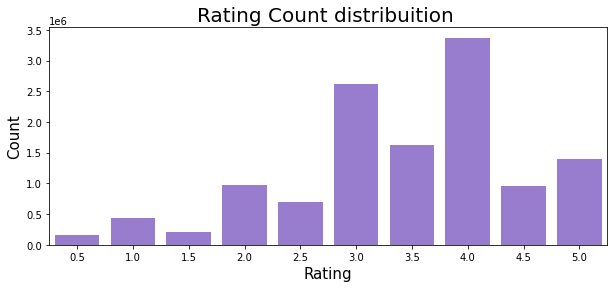

In [11]:
plt.figure(figsize=(10, 4))
graph = sns.countplot(x='rating', data=rating, color='mediumpurple')
graph.set_title("Rating Count distribuition ", fontsize=20)
graph.set_xlabel("Rating", fontsize=15) 
graph.set_ylabel("Count", fontsize=15)
plt.show()

In [268]:
# rating 0~1로 정규화(?) 해주기
min_rating = min(rating['rating'])
max_rating = max(rating['rating'])
print(min_rating, max_rating)

rating['rating'] = rating["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating['rating'])
print('Avg', AvgRating)

0.5 5.0
Avg 0.6537791731343117


In [13]:
# 중복행이 있는지 확인하고 제거
duplicates = rating.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating = rating[~duplicates]

print('> {} duplicates'.format(rating.duplicated().sum()))

> 0 duplicates


### user와 movie 0부터 매핑해주기

In [269]:
# Encoding categorical data
user_ids = rating["userId"].unique().tolist() 
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # {2:0, 6:1, 12:2, 16:3, ...}
user_encoded2user = {i: x for i, x in enumerate(user_ids)} # {0:2, 1:6, 2:12, 3:16, ...}

rating["user"] = rating["userId"].map(user2user_encoded) #user를 0부터 새로운 인덱스로 mapping
n_users = len(user2user_encoded)

In [270]:
movie_ids = rating["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)} # {24833:0, 235:1, 36721:2, 40956:3, ...}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
rating["movie"] = rating["movieId"].map(movie2movie_encoded)
n_movies = len(movie2movie_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_movies))
print("Min rating: {}, Max rating: {}".format(min(rating['rating']), max(rating['rating'])))

Num of users: 26826, Num of animes: 26539
Min rating: 0.0, Max rating: 1.0


In [259]:
rating.head()

,userId,movieId,rating,user,movie
541,7,3,0.555556,0,0
542,7,7,0.555556,0,1
543,7,11,0.777778,0,2
544,7,15,0.333333,0,3
545,7,16,0.555556,0,4


### 200개 이상의 영화를 rating 한 유저들만 추출한 후, 각 유저 별, 애니메이션을 0부터 매핑완료(바꾼 것이 아님 !!)
- user 수 : 26826 (0~26825)
- movie 수 : 26539 (0~26538)

### 모델링

In [271]:
# Shuffle
rating = rating.sample(frac=1, random_state=73)

X = rating[['user', 'movie']].values
y = rating["rating"]

In [18]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating.shape[0] - test_set_size #71418113-10000

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 12461876
> Test set ratings: 10000


In [19]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [20]:
X_train_array
#유저 index
#애니메이션 index

[array([25961,  9313,  6932, ..., 11645,  6334, 23074]),
 array([2113,  480, 4900, ...,   10, 6064, 2587])]

In [21]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam

- embedding

  - input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
  - output_dim: Integer. Dimension of the dense embedding.
  - Input shape : 2D tensor with shape: (batch_size, input_length).
  - Output shape : 3D tensor with shape: (batch_size, input_length, output_dim).

- input shape

  여기서 shape = (1,) 엄밀히 말하면 vector가 한개라는 뜻이됩니다. 데이터 shape이 (5,1)일 경우 5행1열을 가진 데이터라는 뜻이 되는데요. 여기서 행은 무시하고 열!만 shape으로 입력을 해주는 것 입니다. 데이터는 계속 추가 될 수 있으므로 열(feature)만 중요

In [22]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 64
    
    #user
    user = Input(name = 'user', shape = [1]) # [1]=1=(1,)
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)
    user_flat =Flatten(name='FlattenUsers')(user_embedding)
                       
    #animation
    movie = Input(name = 'movie', shape = [1])
    movie_embedding = Embedding(name = 'movie_embedding',
                       input_dim = n_movies, 
                       output_dim = embedding_size)(movie)
    movie_flat =Flatten(name='FlattenMovie')(movie_embedding)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 1)([user_flat, movie_flat])
    #x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

In [23]:
model = RecommenderNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        1716864     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 64)        1698496     movie[0][0]                      
______________________________________________________________________________________________

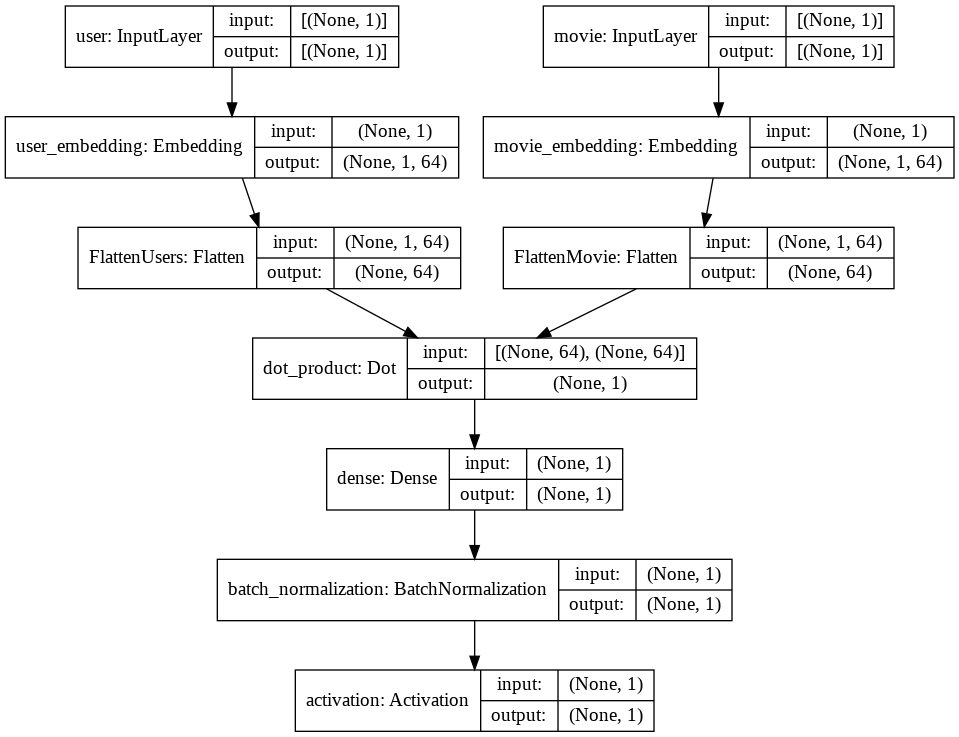

In [24]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./dot.png',show_shapes=True, show_layer_names=True)

In [25]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = EarlyStopping(patience = 3, monitor='val_loss',mode='min', restore_best_weights=True)

checkpoint_filepath = './weights.h5'
# Validation Set을 기준으로 가장 최적의 모델을 찾기 위한 코드입니다.
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

my_callbacks = [
    save_best,
    early_stop   
]

In [26]:
# Model training
#con
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
1247/1247 [==============================] - 47s 24ms/step - loss: 0.6997 - mae: 0.2188 - mse: 0.0770 - val_loss: 0.5979 - val_mae: 0.1383 - val_mse: 0.0321
Epoch 2/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5888 - mae: 0.1304 - mse: 0.0287 - val_loss: 0.5920 - val_mae: 0.1327 - val_mse: 0.0296
Epoch 3/20
1247/1247 [==============================] - 31s 25ms/step - loss: 0.5808 - mae: 0.1226 - mse: 0.0254 - val_loss: 0.5901 - val_mae: 0.1308 - val_mse: 0.0289
Epoch 4/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5766 - mae: 0.1184 - mse: 0.0237 - val_loss: 0.5894 - val_mae: 0.1306 - val_mse: 0.0286
Epoch 5/20
1247/1247 [==============================] - 31s 25ms/step - loss: 0.5739 - mae: 0.1158 - mse: 0.0227 - val_loss: 0.5890 - val_mae: 0.1301 - val_mse: 0.0285
Epoch 6/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5722 - mae: 0.1140 - mse: 0.0220 - val_loss: 0.5890 - val_mae: 0.1302 - val_mse:

In [95]:
#get_weights() : 훈련 중 업데이트 되고 있는 가중치 값 확인 가능한 함수
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

movie_weights = extract_weights('movie_embedding', model)
user_weights = extract_weights('user_embedding', model)

영화 이름 출력하는 함수 만들기

In [60]:
movie=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/movie.csv")
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [64]:
#연도 지우기
movie['title']=movie['title'].str[:-7]

In [65]:
movie

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben,Comedy
27274,131256,"Feuer, Eis & Dosenbier",Comedy
27275,131258,The Pirates,Adventure
27276,131260,Rentun Ruusu,(no genres listed)


In [77]:
id_or_name='Toy Story'
movie[movie.title == 'Toy Story'].title.values[0]

'Toy Story'

In [78]:
# Fixing Names
def getMovieName(id_or_name):
    try: #eng_version 또는 Name의 값으로 return
        name = movie[movie.movieId == id_or_name].movieId.values[0]
        if name is np.nan:
            name = movie[movie.title == id_or_name].title.values[0]
    except:
        print('error')
    
    return name

In [87]:
def getMovieFrame(id_or_name):
    if isinstance(id_or_name, int):
        return movie[movie.movieId == id_or_name]
    if isinstance(id_or_name, str):
        return movie[movie.title == id_or_name]

In [88]:
getMovieFrame('Toy Story')

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy


In [89]:
movie2movie_encoded

{3: 0,
 7: 1,
 11: 2,
 15: 3,
 16: 4,
 17: 5,
 24: 6,
 105: 7,
 122: 8,
 151: 9,
 252: 10,
 260: 11,
 271: 12,
 276: 13,
 316: 14,
 339: 15,
 348: 16,
 351: 17,
 355: 18,
 356: 19,
 357: 20,
 362: 21,
 364: 22,
 377: 23,
 425: 24,
 440: 25,
 480: 26,
 509: 27,
 539: 28,
 553: 29,
 587: 30,
 589: 31,
 590: 32,
 597: 33,
 674: 34,
 708: 35,
 736: 36,
 750: 37,
 780: 38,
 788: 39,
 806: 40,
 852: 41,
 880: 42,
 899: 43,
 908: 44,
 912: 45,
 914: 46,
 920: 47,
 922: 48,
 924: 49,
 928: 50,
 932: 51,
 952: 52,
 1017: 53,
 1020: 54,
 1077: 55,
 1094: 56,
 1095: 57,
 1097: 58,
 1101: 59,
 1183: 60,
 1196: 61,
 1206: 62,
 1210: 63,
 1230: 64,
 1247: 65,
 1253: 66,
 1256: 67,
 1259: 68,
 1265: 69,
 1270: 70,
 1271: 71,
 1272: 72,
 1301: 73,
 1307: 74,
 1343: 75,
 1357: 76,
 1385: 77,
 1391: 78,
 1393: 79,
 1408: 80,
 1409: 81,
 1441: 82,
 1449: 83,
 1466: 84,
 1513: 85,
 1517: 86,
 1544: 87,
 1573: 88,
 1580: 89,
 1597: 90,
 1617: 91,
 1674: 92,
 1682: 93,
 1721: 94,
 1777: 95,
 1882: 96,
 1888

In [100]:
def find_similar_movies(name, n=10, return_dist=False, neg=False):
    try:
        index = getMovieFrame(name).movieId.values[0]
        encoded_index = movie2movie_encoded.get(index)
        weights = movie_weights #anime_weights=extract_weights('anime_embedding', model)
      
        dists = np.dot(weights, weights[encoded_index]) #모든 애니메이션의 임베팅 벡터와 구하고자 하는 애니메이션의 임베팅 벡터와 내적연산하여 유사성을 계산
        sorted_dists = np.argsort(dists) #연관도 순서별로 인덱스를 저장
        #[0.3 0.7 0.02] => [2 0 1]
       

        #자기 자신과는 1이 유사도로 나오므로 +1 해줘야 원하는 개수를 구할 수 있음
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = movie
        
        #print(closest)
        SimilarityArr = []

        #유사하게 나온 영화들의 정보 출력
        for close in closest:
            decoded_id = movie_encoded2movie.get(close)
            #sypnopsis = getSypnopsis(decoded_id)
            movie_frame = getMovieFrame(decoded_id)
            
            movie_name = movie_frame.title.values[0]
            genre = movie_frame.genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": movie_name,
                                  "similarity": similarity,"genre": genre
                                  })
        #print(len(SimilarityArr))
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[1:n] #자기 자신을 제외하고 return 
        #return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [101]:
find_similar_movies('Toy Story', n=5, neg=False)

animes closest to Toy Story


,anime_id,name,similarity,genre
4,3114,Toy Story 2,0.951672,Adventure|Animation|Children|Comedy|Fantasy
3,4886,"Monsters, Inc.",0.894515,Adventure|Animation|Children|Comedy|Fantasy
2,6377,Finding Nemo,0.885671,Adventure|Animation|Children|Comedy
1,78499,Toy Story 3,0.824653,Adventure|Animation|Children|Comedy|Fantasy|IMAX
0,2355,"Bug's Life, A",0.821624,Adventure|Animation|Children|Comedy


### Task 2: Finding Similar Users (User Based Recommendation)

In [128]:
print('> picking up random user')

random_user=rating.sample(1, random_state=54).userId.values[0]
#ratings_per_user = rating.groupby('userId').size()
#random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=34).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 58785


In [117]:
def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = movie
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(name))

In [129]:
similar_users = find_similar_users(int(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

> users similar to #58785


,similar_users,similarity
4,10085,0.840332
3,92584,0.751974
2,22966,0.673519
1,25345,0.667650
0,138103,0.659498


## 유저선호도

In [230]:
rating[rating['userId']==10085].sort_values(by='rating',ascending=False)[:40]

,userId,movieId,rating,user,movie
1489675,10085,1917,1.0,2042,100
1489718,10085,2115,1.0,2042,787
1489862,10085,3147,1.0,2042,1075
1489793,10085,2628,1.0,2042,145
1489514,10085,780,1.0,2042,38
1489429,10085,316,1.0,2042,14
1489538,10085,1090,1.0,2042,1541
1489561,10085,1275,1.0,2042,1553
1489766,10085,2423,1.0,2042,2360
1489558,10085,1266,1.0,2042,958


In [228]:
movie[movie['title']=='Toy Story']

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy


In [222]:

from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=400, height=200, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(8,6)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['genres']:
            if isinstance(genres, str):
                for genre in genres.split('|'):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(userId, plot=False, verbose=0):
    animes_watched_by_user = rating[rating.userId==userId]

    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          userId, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75) #상위 75%의 ranking 저장
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile] # 그 이상의 rating 을 갖는 애니메이션만 추출
    top_animes_user = ( #상위 애니메이션 index 저장
        animes_watched_by_user.sort_values(by="rating", ascending=False).head(20)
        .movieId.values
    )
    
    anime_df_rows = movie[movie["movieId"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["title", "genres"]]
    
    
    
    if plot:
        getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values

> User #58785 has rated 836 movies (avg. rating = 0.6)
> preferred genres


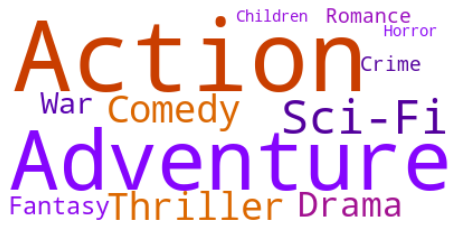

> animes highly rated by this user


,title,genres
108,Braveheart,Action|Drama|War
257,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
352,Forrest Gump,Comedy|Drama|Romance|War
583,Terminator 2: Judgment Day,Action|Sci-Fi
771,"Cable Guy, The",Comedy|Thriller
1017,Die Hard,Action|Crime|Thriller
1171,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi
1173,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1175,Aliens,Action|Adventure|Horror|Sci-Fi
1184,Star Wars: Episode VI - Return of the Jedi,Action|Adventure|Sci-Fi


In [223]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

test=pd.DataFrame(user_pref)
test

In [198]:
genres_list = []
for genres in movie['genres']:
  for genre in genres.split('|'):
    genres_list.append(genre)
set(genres_list)  

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### 유사도가 제일 높은 유저와 장르 선호도 비교(wordcloud)

> User #10085 has rated 592 movies (avg. rating = 0.6)
> preferred genres


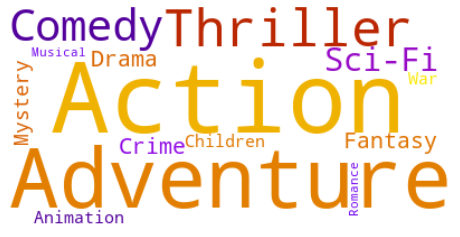

> animes highly rated by this user


,title,genres
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
46,Seven (a.k.a. Se7en),Mystery|Thriller
49,"Usual Suspects, The",Crime|Mystery|Thriller
228,Dumb & Dumber (Dumb and Dumber),Adventure|Comedy
313,Stargate,Action|Adventure|Sci-Fi
583,Terminator 2: Judgment Day,Action|Sci-Fi
586,Batman,Action|Crime|Thriller
721,"Rock, The",Action|Adventure|Thriller
1006,"Sword in the Stone, The",Animation|Children|Fantasy|Musical
1068,Platoon,Drama|War


In [225]:
first_similar_user=similar_users.iloc[:,0][4]
firstsim_user_pref = get_user_preferences(first_similar_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(firstsim_user_pref)

In [234]:

get_user_preferences(int(10085), verbose=0)

,title,genres
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
46,Seven (a.k.a. Se7en),Mystery|Thriller
49,"Usual Suspects, The",Crime|Mystery|Thriller
228,Dumb & Dumber (Dumb and Dumber),Adventure|Comedy
313,Stargate,Action|Adventure|Sci-Fi
583,Terminator 2: Judgment Day,Action|Sci-Fi
586,Batman,Action|Crime|Thriller
721,"Rock, The",Action|Adventure|Thriller
1006,"Sword in the Stone, The",Animation|Children|Fantasy|Musical
1068,Platoon,Drama|War


In [239]:
anime_list = []
for user_id in similar_users.similar_users.values: #유저번호
        pref_list = get_user_preferences(int(user_id), verbose=0) #비슷한 유저a가 시청한 리스트
        pref_list = pref_list[~ pref_list.title.isin(user_pref.title.values)] #user가 시청한 목록은 제거(이미 봤으니 추천해줄 이유 x)
        anime_list.append(pref_list.title.values)

anime_list = pd.DataFrame(anime_list)
sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(10) #제일 많이 추천된(카운트된) 순으로 정렬
sorted_list

,0
"Green Mile, The",3
"Lord of the Rings: The Return of the King, The",2
"Shawshank Redemption, The",2
"Lord of the Rings: The Two Towers, The",2
Dead Poets Society,2
Christmas Vacation (National Lampoon's Christmas Vacation),2
Spider-Man 2,1
Die Hard: With a Vengeance,1
Tommy Boy,1
"Dark Knight, The",1


In [240]:
for i, anime_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getMovieFrame(anime_name)
                anime_id = frame.movieId.values[0]
                genre = frame.genres.values[0]
                #sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({"anime_id": anime_id ,
                                            "n": n_user_pref,
                                            "anime_name": anime_name, 
                                            "Genders": genre, 
                                            #"sypnopsis": sypnopsis
                                           })
            except:
                pass

In [241]:
pd.DataFrame(recommended_animes)

,anime_id,n,anime_name,Genders
0,3147,3,"Green Mile, The",Crime|Drama
1,7153,2,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
2,318,2,"Shawshank Redemption, The",Crime|Drama
3,5952,2,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
4,1246,2,Dead Poets Society,Drama
5,2423,2,Christmas Vacation (National Lampoon's Christm...,Comedy
6,8636,1,Spider-Man 2,Action|Adventure|Sci-Fi|IMAX
7,165,1,Die Hard: With a Vengeance,Action|Crime|Thriller
8,333,1,Tommy Boy,Comedy
9,58559,1,"Dark Knight, The",Action|Crime|Drama|IMAX


In [244]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []
    anime_list = []
    
    #비슷한 유저들이 시청한 애니메이션을 anime_list에 추가(이미 본 애니메이션은 제거)
    for user_id in similar_users.similar_users.values: #유저번호
        pref_list = get_user_preferences(int(user_id), verbose=0) #비슷한 유저a가 시청한 리스트
        pref_list = pref_list[~ pref_list.title.isin(user_pref.title.values)] #user가 시청한 목록은 제거(이미 봤으니 추천해줄 이유 x)
        anime_list.append(pref_list.title.values)
        
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n) #제일 많이 추천된(카운트된) 순으로 정렬
    
    for i, anime_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getMovieFrame(anime_name)
                anime_id = frame.movieId.values[0]
                genre = frame.genres.values[0]
                #sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({"anime_id": anime_id ,
                                            "n": n_user_pref,
                                            "anime_name": anime_name, 
                                            "genres": genre, 
                                            #"sypnopsis": sypnopsis
                                           })
            except:
                pass
    
    return pd.DataFrame(recommended_animes)

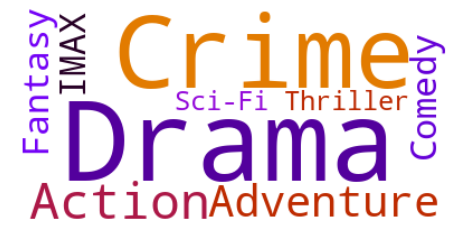


> Top recommendations for user: 58785


,anime_id,n,anime_name,genres
0,3147,3,"Green Mile, The",Crime|Drama
1,7153,2,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
2,318,2,"Shawshank Redemption, The",Crime|Drama
3,5952,2,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
4,1246,2,Dead Poets Society,Drama
5,2423,2,Christmas Vacation (National Lampoon's Christm...,Comedy
6,8636,1,Spider-Man 2,Action|Adventure|Sci-Fi|IMAX
7,165,1,Die Hard: With a Vengeance,Action|Crime|Thriller
8,333,1,Tommy Boy,Comedy
9,58559,1,"Dark Knight, The",Action|Crime|Drama|IMAX


In [247]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

In [286]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating[rating.userId==random_user] #유저a가 시청한 애니메이션 목록
anime_not_watched_df = movie[ # 유저a가 시청하지 않은 애니메이션 목록
    ~movie["movieId"].isin(animes_watched_by_user.movieId.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['movieId']).intersection(set(movie2movie_encoded.keys())) #교집합 만들기
)

anime_not_watched = [[movie2movie_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]] #input
ratings = model.predict(user_anime_array).flatten() #output

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    movie_encoded2movie.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    predd_rating = ratings[index]
    id_ = movie_encoded2movie.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (movie.movieId == id_)
            name = movie[condition]['title'].values[0]
            genre = movie[condition].genres.values[0]
            #score = movie[condition].Score.values[0]
            #sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": predd_rating,
                        "genre": genre, 
                        #'sypnopsis': sypnopsis
                        })

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)

#test
#test=pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)

pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)


Showing recommendations for user: 58785
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre
8,Chouchou (2003),0.950320,Comedy
2,Day of Anger (I giorni dell'ira) (1967),0.948656,Western
4,Holly (2006),0.940761,Drama
7,"Year One, The (L'an 01) (1973)",0.938518,Comedy
9,From Dad to Son (2012),0.938179,Animation|Drama
0,"Lord of the Rings: The Two Towers, The (2002)",0.932566,Adventure|Fantasy
1,"Lord of the Rings: The Return of the King, The...",0.931964,Action|Adventure|Drama|Fantasy
3,Raiders of the Lost Ark: The Adaptation (1989),0.931439,Action|Adventure|Thriller
6,Dragon Ball Z: The Return of Cooler (Doragon b...,0.929759,Action|Adventure|Animation
5,"Merry Widow, The (1925)",0.928742,Drama|Romance
